## 2022-10-2122 SN 2022vqz

*An analysis pipeline for our second night of supernova observation*

For additional pipeline ideas, we may want to study [a notebook by Vivek Kumar Jha](https://github.com/viveikjha/aperture_photometry/blob/master/Reduction_demonstration.ipynb) from Aryabhatta Research Institute of Observational Sciences ([ARIES](https://www.aries.res.in)) and [a notebook by Erik Tollerud](https://notebook.community/LSSTC-DSFP/LSSTC-DSFP-Sessions/Session5/Day1/python_imred) from the Space Telescope Science Institute ([STScI](https://www.stsci.edu)).

### Calibrate

We are using a slightly non-standard but pleasantly clean calibration procedure which requires
the lights and the darks to have the same exposure duration (typically of order 30s),
and the flats and the biases to have the same exposure duration (typically 1s). The more standard but less clean
procedure involves "scaling" the darks.

In [98]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
from astropy.visualization import imshow_norm, PercentileInterval, MinMaxInterval, SqrtStretch, LogStretch
import matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from photutils.aperture import RectangularAperture, RectangularAnnulus
from photutils.aperture import ApertureStats, aperture_photometry

In [2]:
# for an analyses of an observation run done with only a single filter,
# only the observation_date and the exposure times
# will need to be changed

observation_date = '2022-10-2425'
light_exposure = 30 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality

In [3]:
# directory where the data being analyzed is kept

data_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)

In [4]:
# subdirectories -- all relative to data_directory

light_directory = os.path.join(data_directory, 'light')
dark_directory = os.path.join(data_directory, 'dark')
flat_directory = os.path.join(data_directory, 'flat')
bias_directory = os.path.join(data_directory, 'bias')

# the aligned directory is *written to* not read from

aligned_directory = os.path.join(data_directory, 'aligned')
if not os.path.exists(aligned_directory):
    os.makedirs(aligned_directory)

In [5]:
light_files = ImageFileCollection(light_directory).files_filtered(include_path='True')
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files = ImageFileCollection(flat_directory).files_filtered(include_path='True')
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

In [6]:
lights = [CCDData.read(file, unit=u.adu) for file in light_files]
darks = [CCDData.read(file, unit=u.adu) for file in dark_files]
flats = [CCDData.read(file, unit=u.adu) for file in flat_files]
biases = [CCDData.read(file, unit=u.adu) for file in bias_files]

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [7]:
method = 'median'  # the method can be changed to 'average'

master_dark = combine(darks, method=method)
master_flat = combine(flats, method=method)
master_bias = combine(biases, method=method)

In [8]:
lights_subtracted = [subtract_dark(light,
                                   master_dark,
                                   data_exposure=light_exposure,
                                   dark_exposure=dark_exposure,
                                   scale=False)
                     for light in lights]

master_flat_subtracted = subtract_dark(master_flat,
                                       master_bias,
                                       data_exposure=flat_exposure,
                                       dark_exposure=bias_exposure,
                                       scale=False)

In [9]:
lights_calibrated = [flat_correct(l, master_flat_subtracted) for l in lights_subtracted]

/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/astropy/nddata/nduncertainty.py:684: RuntimeWarning: invalid value encountered in true_divide
  return from_variance((left + right + correlation_sign * corr) /


### Examine Calibration

Here we experiment with LogStretch and SqrtStretch from astropy.visualization. Principally, we follow the examples in the [Image stretching and normalization](https://docs.astropy.org/en/stable/visualization/normalization.html) documentation from astropy.visualization.

In [10]:
light = lights[0]

In [11]:
calibrated_light = lights_calibrated[0]

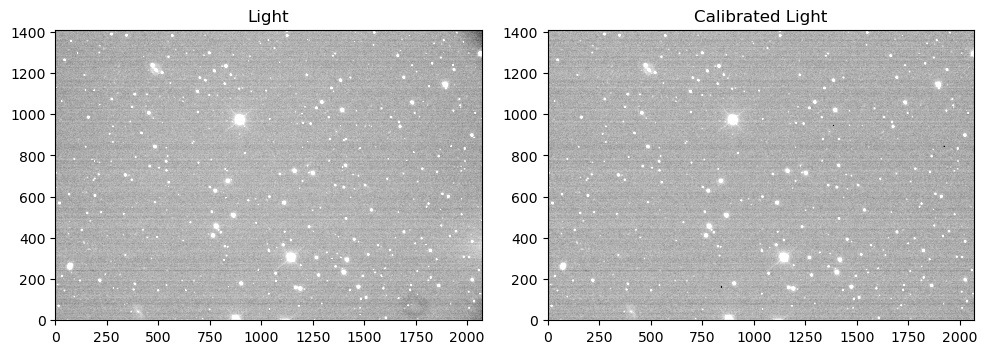

In [12]:
interval_95 = PercentileInterval(95)
sqrt_stretch = SqrtStretch()
log_stretch = LogStretch()

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

im_l, norm_l = imshow_norm(light, axes[0], cmap='gray', origin='lower',
                       interval=interval_95, stretch=sqrt_stretch)
axes[0].set_title("Light")

im_c_l, norm_c_l = imshow_norm(calibrated_light, axes[1], cmap='gray', origin='lower',
                       interval=interval_95, stretch=sqrt_stretch)
axes[1].set_title("Calibrated Light")

plt.tight_layout()
plt.show()

Our calibrated images appear to have both vignetting and the shadows of dust motes well-removed.

### Create and Write the Aligned Lights

From here on, we only have use for the calibrated lights. The last step before combining them is alignment.

In [13]:
# This attempt to rotate and zoom lights_calibrated[1] is not working.
# The idea was to stress-test aa.register().
# Just comment the stress test out for now.

# from scipy.ndimage import rotate, zoom
# image_to_rotate = lights_calibrated[1]
# image_rotated = rotate(image_to_rotate, angle=30.0, reshape=False)
# image_rotated_and_zoomed = zoom(image_rotated, 1.5, order=2)
# lights_calibrated[1] = image_rotated_and_zoomed

In [14]:
reference_light = lights_calibrated[0]

In [15]:
lights_aligned_with_footprints = [aa.register(l, reference_light, detection_sigma=3.0) for l in lights_calibrated]

In [16]:
for i in range(0, len(lights)):
    light_header = lights[i][0].header
    light_aligned_data = lights_aligned_with_footprints[i][0]
    aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[i]))
    aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
    fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)

### Examine Alignment

Let's examine the last aligned image in comparison with the first (reference) image.

In [17]:
light = lights_calibrated[-1]

In [18]:
light_aligned, footprint = lights_aligned_with_footprints[-1]

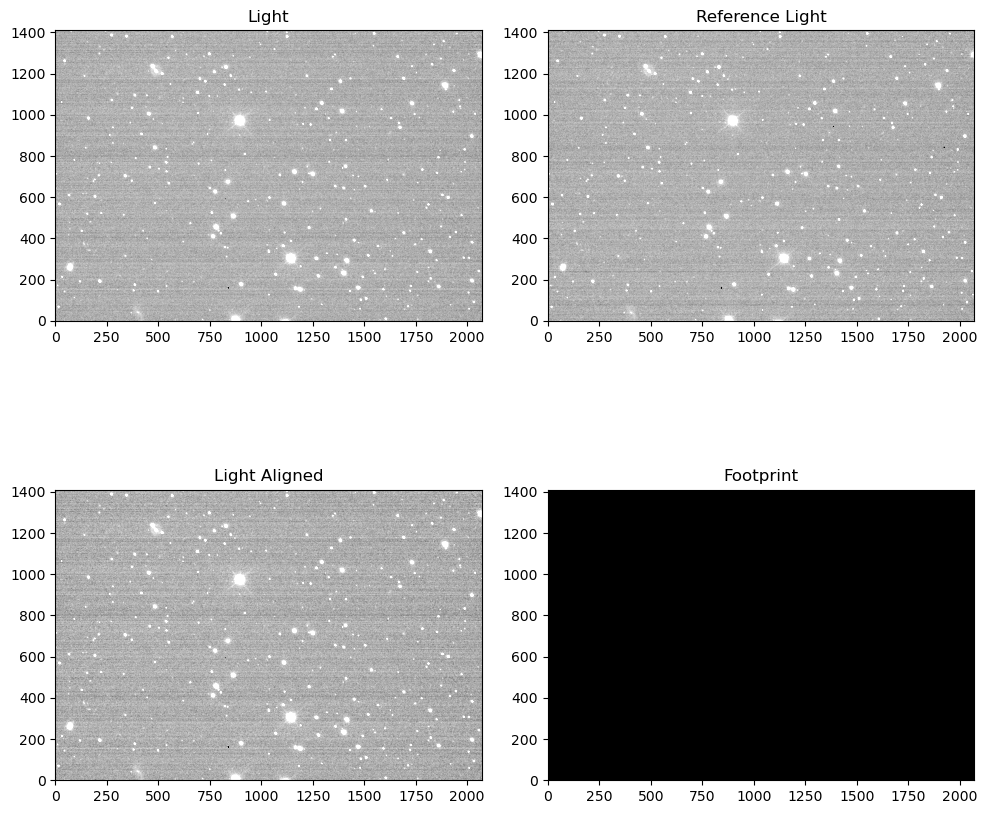

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

_, _ = imshow_norm(light, axes[0, 0], cmap='gray', origin='lower',
           interval=interval_95, stretch=sqrt_stretch)
axes[0, 0].set_title("Light")

_, _ = imshow_norm(reference_light, axes[0, 1], cmap='gray', origin='lower',
           interval=interval_95, stretch=sqrt_stretch)
axes[0, 1].set_title("Reference Light")

_, _ = imshow_norm(light_aligned, axes[1, 0], cmap='gray', origin='lower',
           interval=interval_95, stretch=sqrt_stretch)
axes[1, 0].set_title("Light Aligned")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', origin='lower')
axes[1, 1].set_title("Footprint")

plt.tight_layout()
plt.show()

The auto-guider locked on so well that there is nothing to see.

### Combine the Aligned Lights

In [20]:
aligned_files = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
combined_light = combine([CCDData.read(file, unit=u.adu) for file in aligned_files], method=method)

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.
/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Examine the Combined Light

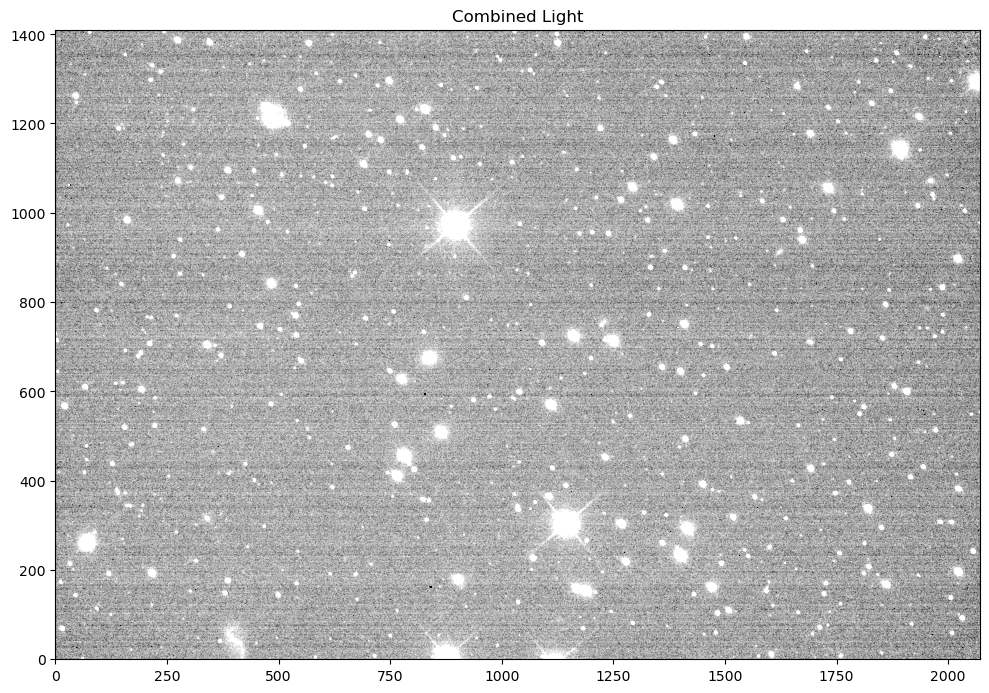

In [61]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

# log_stretch = LogStretch()  # the default log stretch is not as good as the default square-root stretch

_, _ = imshow_norm(combined_light, axes, cmap='gray', origin='lower', interval=interval_95, stretch=sqrt_stretch)

axes.set_title("Combined Light")

plt.tight_layout()
plt.show()

### Find All Stars in Image

In [100]:
bkg_sigma = mad_std(combined_light)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(combined_light.data)

/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Applications/Anaconda/anaconda3/envs/transient/lib/python3.9/site-packages/numpy/lib/function_base.py:3685: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


In [101]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,1.4855176876556029,1.4750168817943283,0.2573087092059883,-0.38096257165639635,0.1505011918485376,25,0.0,17.78394080699412,4.614143794207541,-1.660227811644839
2,2069.2585310563472,1.4780768934952473,0.21530993042888738,0.29629476817789135,-0.28100706202179665,25,0.0,16.33234394213674,4.261179300763518,-1.573824521780112
3,878.5376869439793,2.948553207168302,0.47725787594112135,0.05623899393462324,0.1330914508145695,25,0.0,43616.2121747199,9787.472753982525,-9.976676415235495
4,583.4917469762205,3.564390348962884,0.526893341129667,0.07783140206682924,0.31404242688832,25,0.0,30.22117922433207,2.6031545906811884,-1.0387498996106157
5,846.0505452577061,4.71995400164489,0.630508656356427,0.3049440371470769,0.18998215241345118,25,0.0,26.379725457085257,1.5320052996929008,-0.4631506691543244
6,1006.266956526373,3.714416261763952,0.5855841266366467,-0.8443164269784744,-0.0019011236026210592,25,0.0,21.365972635306726,1.141725471012055,-0.14390422484135834
7,1460.1969306461071,3.9133550045564,0.31421743938220753,0.8547512080148029,0.4449377814412214,25,0.0,19.206776166810535,1.0973284250477637,-0.10084157312803635
8,1893.82824297989,4.1225309631569615,0.46061122760563716,-0.32239450047115925,-0.9928580024772993,25,0.0,19.494144421095903,1.0353460756676378,-0.03771385426611377
9,2035.2778930578543,4.161437051018136,0.4491128264649142,0.047848908844976855,-0.20875421798963992,25,0.0,19.693902917883307,1.2772373412769165,-0.2656790176873254


### Place Apertures and Annuli

In [73]:
positions = [(1000, 1000.), (1200., 1200.)]
aperture_width, aperture_height = 20.0, 20.0
annulus_inner_width, annulus_inner_height = 40.0, 40.0
annulus_outer_width, annulus_outer_height = 60.0, 60.0

In [79]:
apertures = RectangularAperture(positions,
                                aperture_width,
                                aperture_height)

annuli = RectangularAnnulus(positions,
                            annulus_inner_width,
                            annulus_outer_width,
                            annulus_outer_height,
                            annulus_inner_height)  # the whacky ordering of parameters is per the documtation

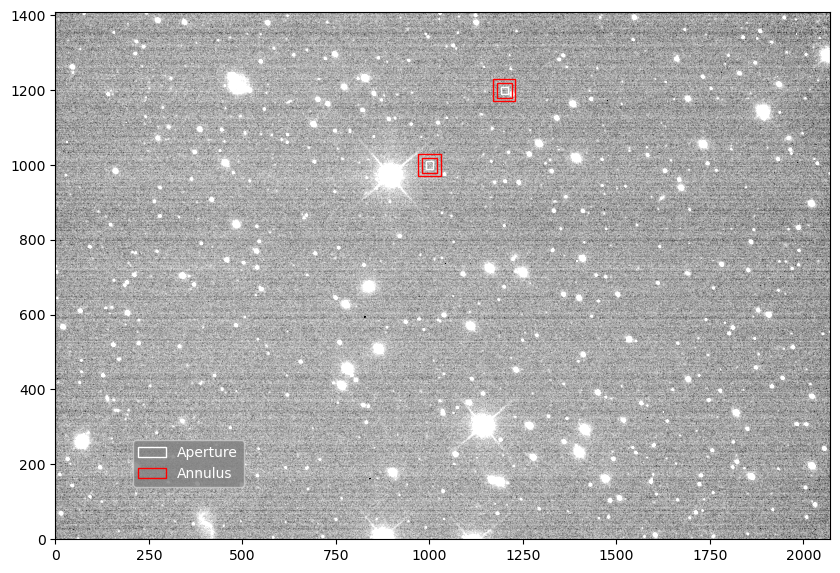

In [94]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

_, _ = imshow_norm(combined_light, axes, cmap='gray', origin='lower', interval=interval_95, stretch=sqrt_stretch)

aperture_patches = apertures.plot(color='white', label='Aperture')

annulus_patches = annuli.plot(color='red', label='Annulus')

handles = (ap_patches[0], ann_patches[0])

plt.legend(loc=(0.1, 0.1), facecolor='gray', labelcolor='white', handles=handles)

### Perform Aperture-Annulus Photometry

In [95]:
apertures_table = aperture_photometry(combined_light, apertures)
annuli_table = aperture_photometry(combined_light, annuli)

In [96]:
apertures_table

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,adu,adu
int64,float64,float64,float64,float64
1,1000.0,1000.0,7127.145435328535,12.821779488878793
2,1200.0,1200.0,7005.775304058272,13.01056690661224


In [97]:
annuli_table

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,adu,adu
int64,float64,float64,float64,float64
1,1000.0,1000.0,35773.9269062955,28.08824444384984
2,1200.0,1200.0,39313.72515780272,33.36309927821421
